**Importing All Libraries**

In [1]:
import math
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import spacy
import en_core_web_lg;

 **Load English tokenizer, tagger, parser, NER and word vectors through en_core_web_lg**

In [2]:
nlp = spacy.load("en_core_web_lg")
from spacy.matcher import PhraseMatcher

In [3]:
print(nlp)

**Automatically Reading Resumes**

In [4]:
mypath = (r"C:\Users\HP\Desktop\Resume Screening System\Resume_Screening_System\Resume")

onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file, 'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:
        pageObj = fileReader.getPage(count)
        count += 1
        t = pageObj.extractText()
        print(t)
        text.append(t)
    return text

**Function that does phrase matching and builds a candidate profile**

In [5]:
def create_profile(file, idx):
    text = pdfextract(file)
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    
    # below is the csv where we have all the keywords, you can customize your own
    
    keyword_dict = pd.read_csv(r'C:\Users\HP\Desktop\Resume Screening System\Resume_Screening_System\Skill_Set dictionary.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis=0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis=0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis=0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis=0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis=0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis=0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis=0)]
    WebDev_words = [nlp(text) for text in keyword_dict['Web Development'].dropna(axis=0)]
    
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    matcher.add('WebDev', None, *WebDev_words)
    doc = nlp(text)

    d = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]
        span = doc[start: end]
        d.append((rule_id, span.text))
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i, j in Counter(d).items())

    df = pd.read_csv(StringIO(keywords), names=['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ', 1).tolist(), columns=['Subject', 'Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(', 1).tolist(), columns=['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'], df2['Keyword'], df2['Count']], axis=1)
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]

    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2), names=['Candidate Name'])

    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis=1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace=True)
    

    ## Calculating Scoring of Candidate :

    tot_sum = df3['Count'].sum();
    score.append((dataf['Candidate Name'][0], tot_sum));

    return (dataf)

**Assigning weights to Skill_set**

In [6]:
data_map = dict();

def data_dict():
    global data_map;

    data_map["DE"] = 4;
    data_map["DL"] = 10;
    data_map["ML"] = 9;
    data_map["NLP"] = 10;
    data_map["Python"] = 5;
    data_map["R"] = 5;
    data_map["Stats"] = 8;
    data_map["WebDev"] = 2;

**Calculating Scores**

In [7]:
def score_calc():
    global score, final_database2, data_map;
    mm = []
    col = [];
    for i in final_database2.columns:
        col.append(i);

    name = "";
    for i in range(len(final_database2)):
        name = final_database2.iloc[i, 0];
        subsum = 0;
        for j in range(1, len(final_database2.columns)):
            num1 = final_database2.iloc[i, j];
            num2 = data_map.get(col[j]);
            subsum += int(num1) * num2;

        mm.append((name, subsum));

    score = mm;

**Tuple Sorting Function**

In [8]:
def Sort_Tuple(tup):
    
    # getting length of list of tuples
    
    lst = len(tup)
    for i in range(0, lst):

        for j in range(0, lst - i - 1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup

In [9]:
from prettytable import PrettyTable


def Sel_printer(show):
    global score, selected;
    num_sel = math.ceil(len(score) / show);
    selected = [];

    Sort_Tuple(score);

    j = len(score) - 1;
    while (j > 0 and num_sel > 0):
        selected.append((score[j][0], score[j][1]));
        num_sel -= 1;
        j -= 1;

    t = PrettyTable(['Name', 'Score'])
    for i in range(len(selected)):
        t.add_row([selected[i][0], selected[i][1]])

    print(t)

**code to count words under each category and visulaize it through Matplotlib**

In [10]:
def data_plot():
    global final_database2;
    final_database2 = final_database['Keyword'].groupby(
        [final_database['Candidate Name'], final_database['Subject']]).count().unstack()
    final_database2.reset_index(inplace=True)
    final_database2.fillna(0, inplace=True)
    new_data = final_database2.iloc[:, 1:]
    new_data.index = final_database2['Candidate Name']
    import matplotlib.pyplot as plt

    plt.rcParams.update({'font.size': 10})
    ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25, 7), stacked=True)
    labels = []
    for j in new_data.columns:
        for i in new_data.index:
            label = str(j) + ": " + str(new_data.loc[i][j])
            labels.append(label)
    patches = ax.patches
    for label, rect in zip(labels, patches):
        width = rect.get_width()
        if width > 0:
            x = rect.get_x()
            y = rect.get_y()
            height = rect.get_height()
            ax.text(x + width / 2., y + height / 2., label, ha='center', va='center')
    plt.show()

In [11]:
# function ends

final_database = pd.DataFrame();
final_database2 = pd.DataFrame();
score = [];
selected = [];

**Calling all Functions in main class**

Software Engineer - Flextronics technologies (India) Pvt ltd
Bengaluru, Karnataka

 2 years of experience in software application development using .Net 
technology solutions. 

 Having hands on experience in developing 
applications using Dot Net technologies like ASP.Net, ADO.Net, C#, MS SQL 
Server, SSRS. 

 As experienced, detail-oriented MES with strong problem 
solving &amp; Project management skills. Expertise in MES (Manufacturing 
Execution Systems) Application implementation, SQL Production databases 
and being a part the Team size of (7) MES support Engineer's to resolve 
the day to day Shop floor issues. Flex Flow is a shop-floor control data-
collection system that helps to improve production efficiency. Currently 
working with Flex Technologies in Bangalore. 

 Extensive experience in 
requirement gathering, implementation, Validation and support 
manufacturing applications in electronic manufacturing company. 

 
Consulting: Functional expertise in complete life cycle im

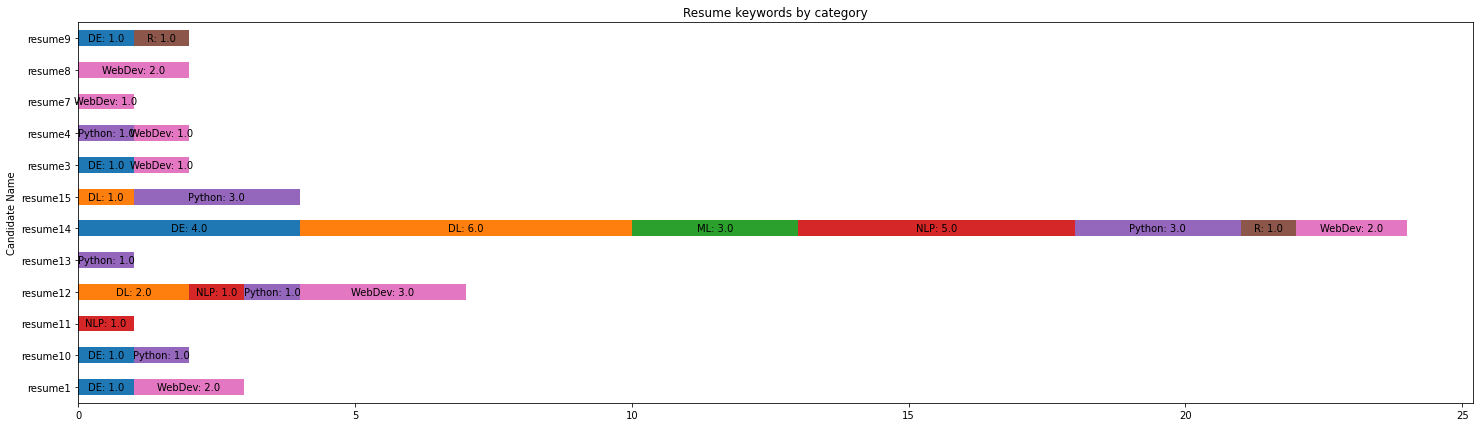

Subject Candidate Name   DE   DL   ML  NLP  Python    R  WebDev
0              resume1  1.0  0.0  0.0  0.0     0.0  0.0     2.0
1             resume10  1.0  0.0  0.0  0.0     1.0  0.0     0.0
2             resume11  0.0  0.0  0.0  1.0     0.0  0.0     0.0
3             resume12  0.0  2.0  0.0  1.0     1.0  0.0     3.0
4             resume13  0.0  0.0  0.0  0.0     1.0  0.0     0.0
5             resume14  4.0  6.0  3.0  5.0     3.0  1.0     2.0
6             resume15  0.0  1.0  0.0  0.0     3.0  0.0     0.0
7              resume3  1.0  0.0  0.0  0.0     0.0  0.0     1.0
8              resume4  0.0  0.0  0.0  0.0     1.0  0.0     1.0
9              resume7  0.0  0.0  0.0  0.0     0.0  0.0     1.0
10             resume8  0.0  0.0  0.0  0.0     0.0  0.0     2.0
11             resume9  1.0  0.0  0.0  0.0     0.0  1.0     0.0
Score Card of the Candidates : 
+----------+-------+
|   Name   | Score |
+----------+-------+
| resume14 |  177  |
| resume12 |   41  |
| resume15 |   25  |
| resume11

In [12]:
def main():
    global final_database, final_database2, data_map;

    i = 0;
    while i < len(onlyfiles):
        file = onlyfiles[i];
        dat = create_profile(file, i);
        final_database = final_database.append(dat);
        i += 1;
        print(final_database);

    data_dict();

    data_plot();

    print(final_database2);

    score_calc();

    print("Score Card of the Candidates : ");
    Sel_printer(1);

    print("Selected Candidates :");
    Sel_printer(10);


if __name__ == '__main__':
    main();